# House Price Prediction & Improvement Model

<font color=blue>_Patrice Kontchou, Chase Rendal, Lu Yu, Zack Zbar_

_NYC DSA bootcamp, June, 2020_

## Table of Contents
1. [Data Preparation](#data)
2. [Lasso](#lasso)
3. [Elastic Net](#en)
4. [Random Forest](#rf)
5. [Multiple Linear Regression](#mlr)

In [3]:
## Packages Required
# data wrangling
import numpy as np
import pandas as pd
import math
# statistics
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
# machine learning
from sklearn import datasets, tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
# ploting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
## Settings
%matplotlib inline
#pd.describe_option('display')
pd.set_option('display.max_columns', None)  
pd.set_option('display.min_rows', 1) # combined with max_rows to show all rows 
pd.set_option('display.max_rows', None)  

## Data Input
<a id='data'></a>

In [179]:
## read in csv
trainf = pd.read_csv('../processed_data/train_full.csv')
traino = pd.read_csv('../processed_data/train_ordinal.csv')
traind = pd.read_csv('../processed_data/train_dummy.csv')
traindo = pd.read_csv('../processed_data/train_dummy_ordinal.csv')

In [180]:
## set Id as index
trainf = trainf.set_index('Id')
traino = traino.set_index('Id')
traind = traind.set_index('Id')
traindo = traindo.set_index('Id')

In [183]:
# check data set dimensions
print(trainf.shape)
print(traino.shape)
print(traind.shape)
print(traindo.shape)

(1460, 80)
(1460, 84)
(1460, 286)
(1460, 226)


## Model Fitting

### 1. Lasso Regression
<a id='lasso'></a>

### _data set preparation: outlier exclusion_

In [21]:
df = traindo.copy() # use ordinal dummy data set: all columns numeric
drop_rows = df[df.index.isin([524, 1299])].index # high influential outliers of SalePrice, drop out reason stated in EDA
print("df shape before drop outlier rows:", df.shape) 
df.drop(drop_rows, inplace=True)
print("df shape after drop outlier rows:", df.shape)
df.head()

df shape before drop outlier rows: (1460, 226)
df shape after drop outlier rows: (1458, 226)


,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,decade_YearBuilt,decade_YearRemodAdd,decade_GarageYrBlt,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_fv,MSZoning_rh,MSZoning_rl,MSZoning_rm,Street_pave,Alley_nothing,Alley_pave,LotShape_ir2,LotShape_ir3,LotShape_reg,LandContour_hls,LandContour_low,LandContour_lvl,Utilities_nosewa,LotConfig_culdsac,LotConfig_fr2,LotConfig_fr3,LotConfig_inside,Neighborhood_blueste,Neighborhood_brdale,Neighborhood_brkside,Neighborhood_clearcr,Neighborhood_collgcr,Neighborhood_crawfor,Neighborhood_edwards,Neighborhood_gilbert,Neighborhood_idotrr,Neighborhood_meadowv,Neighborhood_mitchel,Neighborhood_names,Neighborhood_noridge,Neighborhood_npkvill,Neighborhood_nridght,Neighborhood_nwames,Neighborhood_oldtown,Neighborhood_sawyer,Neighborhood_sawyerw,Neighborhood_somerst,Neighborhood_stonebr,Neighborhood_swisu,Neighborhood_timber,Neighborhood_veenker,Condition1_feedr,Condition1_norm,Condition1_posa,Condition1_posn,Condition1_rrae,Condition1_rran,Condition1_rrne,Condition1_rrnn,Condition2_feedr,Condition2_norm,Condition2_posa,Condition2_posn,Condition2_rrae,Condition2_rran,Condition2_rrnn,BldgType_2fmcon,BldgType_duplex,BldgType_twnhs,BldgType_twnhse,HouseStyle_1.5unf,HouseStyle_1story,HouseStyle_2.5fin,HouseStyle_2.5unf,HouseStyle_2story,HouseStyle_sfoyer,HouseStyle_slvl,RoofStyle_gable,RoofStyle_gambrel,RoofStyle_hip,RoofStyle_mansard,RoofStyle_shed,RoofMatl_compshg,RoofMatl_membran,RoofMatl_metal,RoofMatl_roll,RoofMatl_tar&grv,RoofMatl_wdshake,RoofMatl_wdshngl,Exterior1st_asphshn,Exterior1st_brkcomm,Exterior1st_brkface,Exterior1st_cblock,Exterior1st_cemntbd,Exterior1st_hdboard,Exterior1st_imstucc,Exterior1st_metalsd,Exterior1st_plywood,Exterior1st_stone,Exterior1st_stucco,Exterior1st_vinylsd,Exterior1st_wd sdng,Exterior1st_wdshing,Exterior2nd_asphshn,Exterior2nd_brk cmn,Exterior2nd_brkface,Exterior2nd_cblock,Exterior2nd_cmentbd,Exterior2nd_hdboard,Exterior2nd_imstucc,Exterior2nd_metalsd,Exterior2nd_other,Exterior2nd_plywood,Exterior2nd_stone,Exterior2nd_stucco,Exterior2nd_vinylsd,Exterior2nd_wd sdng,Exterior2nd_wd shng,MasVnrType_brkface,MasVnrType_nothing,MasVnrType_stone,Foundation_cblock,Foundation_pconc,Foundation_slab,Foundation_stone,Foundation_wood,Heating_gasa,Heating_gasw,Heating_grav,Heating_othw,Heating_wall,CentralAir_y,Electrical_fusef,Electrical_fusep,Electrical_mix,Electrical_sbrkr,GarageType_attchd,GarageType_basment,GarageType_builtin,GarageType_carport,GarageType_detchd,GarageType_nothing,PavedDrive_p,PavedDrive_y,Fence_gdwo,Fence_mnprv,Fence_mnww,Fence_nothing,MiscFeature_nothing,MiscFeature_othr,MiscFeature_shed,MiscFeature_tenc,SaleType_con,SaleType_conld,SaleType_conli,SaleType_conlw,SaleType_cwd,SaleType_new,SaleType_oth,SaleType_wd,SaleCondition_adjland,SaleCondition_alloca,SaleCondition_family,SaleCondition_normal,SaleCondition_partial,logSalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,65,8450,3,7,5,2003,2003,196,4,3,4,3,1,6,706,1,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,2003,2,2,548,3,3,0,61,0,0,0,0,0,0,2,2008,208500,10,10,10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0

### _hyperparameter alpha selection for plotting_

In [22]:
## split to train & validation
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(['SalePrice', 'logSalePrice'], axis = 1), df.logSalePrice, test_size = 0.2, random_state = 4)

In [53]:
## single Lasso Pilot Test
lasso = Lasso(normalize=True, max_iter=2000)
lasso.set_params(alpha = 1e-4)
kf5 = KFold(n_splits = 5, shuffle = True, random_state = 4)

lasso.fit(xtrain, ytrain)
lasso_scores = cross_val_score(estimator = lasso, X = xtrain, y = ytrain, cv = kf5)
print("lasso cv score:", lasso_scores.mean())
print("lasso train score", lasso.score(xtrain, ytrain))

lasso cv score: 0.9093233849953724
lasso train score 0.9307376932483421


In [87]:
## manual grid search of Lasso: varying alpha

lasso = Lasso(normalize=True, max_iter=2000)
alphas = np.linspace(1e-5, 1e-2, 100)

coefs = []
scores_cv = []
scores_train = []

# loop through all alpha values to get lasso coefficients, cv scores, and train scores
for alpha in alphas:
    lasso.set_params(alpha = alpha)
    lasso.fit(xtrain, ytrain)
    coefs.append(lasso.coef_)
    
    lasso_score_cv = cross_val_score(estimator = lasso, X = xtrain, y = ytrain, cv = kf5)
    scores_cv.append(lasso_score_cv)
    
    lasso_score_train = lasso.score(xtrain, ytrain)
    scores_train.append(lasso_score_train)

In [91]:
# lasso coef & score dataframe
coefs_lasso = pd.DataFrame(coefs, index = alphas, columns = xtrain.columns)

# compute & align train and validation score of the Lasso model
scores_cv_lasso = pd.DataFrame(scores_cv, index = alphas, columns = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
scores_cv_lasso['validation_score'] = scores_cv_lasso.mean(axis =1)
scores_train_lasso = pd.DataFrame(scores_train, index = alphas, columns=["train_score"])
scores_lasso = pd.concat([scores_cv_lasso.validation_score, scores_train_lasso], axis=1)
scores_lasso.head()

,validation_score,train_score
0.000010,0.898988,0.945187
0.000111,0.909615,0.929758
0.000212,0.907189,0.920620
0.000313,0.901409,0.911185
0.000414,0.895685,0.902254


In [122]:
## Lasso important predictors
lasso_coef_man = coefs_lasso[coefs_lasso.gt(0)].sum(axis = 0).sort_values(ascending = False) # lasso coefficient manual hyperparameter tuning
lasso_coef_imp_man = lasso_coef[lasso_coef > 0]
lasso_coef_imp_man[0:10]

OverallQual             6.753186
GarageCars              1.366059
KitchenQual             0.792301
MSZoning_rl             0.629894
CentralAir_y            0.618254
Neighborhood_crawfor    0.534451
SaleType_new            0.434298
MSZoning_fv             0.416800
MSZoning_rh             0.381788
GarageFinish            0.374094
dtype: float64

Text(0.5, 1.0, 'Lasso Coefficients as a Function of the Regularization')

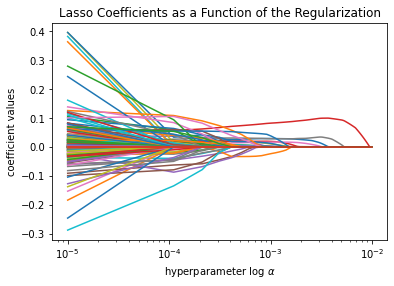

In [125]:
## Lasso plot: hyperparameter lambda
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name])
    plt.xscale("log") # optional
plt.xlabel(r'hyperparameter log $\alpha$')
plt.ylabel(r'coefficient values')
plt.title('Lasso Coefficients as a Function of the Regularization')

Text(0.5, 1.0, 'Lasso Train vs Validation Score')

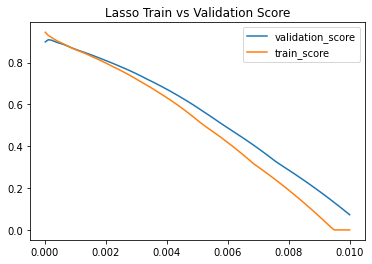

In [149]:
## Lasso plot: scores
for name in scores_lasso.columns:
    plt.plot(scores_lasso.index, scores_lasso[name], label = name)
plt.legend(loc = 1)
plt.title("Lasso Train vs Validation Score")

### _grid search of Lasso_

In [109]:
## Gridsearch of Lasso
alphas = np.linspace(1e-5, 1e-2, 100)
params_lasso = [{'alpha':alphas, 'max_iter': [2000]}]
kf5 = KFold(n_splits = 5, shuffle = True, random_state = 4)
grid_lasso = GridSearchCV(estimator = Lasso(normalize=True), param_grid = params_lasso, cv = kf5, 
                          scoring = 'neg_mean_squared_error', return_train_score = True, refit = True)
grid_lasso.fit(xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-05, 1.10909091e-04, 2...
       8.48636364e-03, 8.58727273e-03, 8.68818182e-03, 8.78909091e-03,
       8.89000000e-03, 8.99090909e-03, 9.09181818e-03, 9.19272727e-03,
       9.29363636e-03, 9.39454545e-03, 9.49545455e-03, 9.59636364e-03,
       9.69727273e-03, 9.79818182e-03, 9.89909091e-03, 1.00000000e-02]),
                          'max_iter': [2000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [148]:
print("Lasso best parameters are", grid_lasso.best_params_)
model_lasso = grid_lasso.best_estimator_
print("Lasso best train score is", model_lasso.score(xtrain, ytrain))

Lasso best parameters are {'alpha': 0.00011090909090909092, 'max_iter': 2000}
Lasso best train score is 0.9297583427780511


In [144]:
# Lasso coefficients of significant predictors
lasso_coef = pd.DataFrame(model_lasso.coef_, index = xtrain.columns, columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
lasso_coef_abs = pd.DataFrame({'abs_coef':abs(model_lasso.coef_), 'coef': model_lasso.coef_}, index = xtrain.columns).sort_values(by = 'abs_coef', ascending = False)
lasso_coef_imp = lasso_coef_abs[lasso_coef_abs['abs_coef']>0]
print(f"# of predictors before Lasso:", lasso_coef_abs.shape[0])
print(f"# of predictors after Lasso:", lasso_coef_imp.shape[0])
#display(lasso_coef_imp)
lasso_coef_imp.to_csv("../output/lasso_coef_imp.csv") # coef is for raw data, not for normalized data

# of predictors before Lasso: 224
# of predictors after Lasso: 87


In [129]:
# Lasso model error: MSE & RMSE
ytrain_lasso = model_lasso.predict(xtrain)
ytest_lasso = model_lasso.predict(xtest)

MSE = mean_squared_error(ytrain, ytrain_lasso)
RMSE = np.sqrt(mean_squared_error(ytrain, ytrain_lasso)) # no written function, need to manually calculate
print(f"MSE is {MSE}\nRMSE is {RMSE}")

MSE is 0.011117486128894079
RMSE is 0.10543949036719628


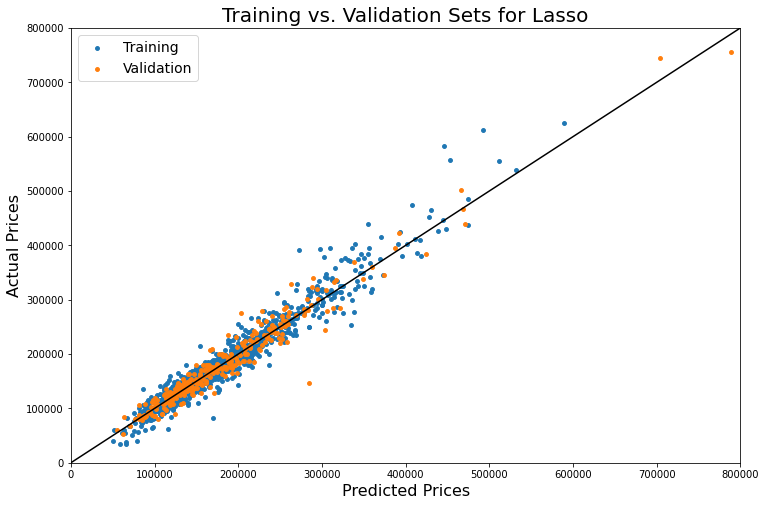

In [143]:
## plot error of train vs validation data
plt.figure(figsize=(12,8))
plt.scatter(np.exp(ytrain_lasso), np.exp(ytrain), marker="o", s=15, label = "Training")
plt.scatter(np.exp(ytest_lasso), np.exp(ytest), marker="o", s=15, label="Validation")
plt.title("Training vs. Validation Sets for Lasso", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.legend(loc = "upper left", fontsize = 14)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.plot([0, 800000], [0, 800000], 'black') # ideal predict-
#plt.show()
plt.savefig('../output/lasso_train_validation_compare.png')

## 2. Elastic Net
<a id='en'></a>

### _data frame set up_

In [151]:
## drop non-significant columns based on Lasso
df_reduce = df[lasso_coef_imp.index]
xtrain_reduce = xtrain[lasso_coef_imp.index]

### _grid search of Elastic Net_

In [164]:
## Gridsearch of ElasticNet

# set hyperparameter space
alphas = np.linspace(1e-10, 10, 100)
rhos = np.linspace(0.1, 1, 10)
rhos = np.append(rhos, np.linspace(0.91, 0.99, 9))
# set Elestic Net model
params_elasticnet = [{'alpha': alphas, 'l1_ratio': rhos, 'max_iter': [2000]}]
kf5 = KFold(n_splits=5, shuffle=True, random_state=4)
grid_elasticnet = GridSearchCV(estimator=ElasticNet(normalize=True), param_grid=params_elasticnet, 
                               return_train_score=True, refit=True)
grid_elasticnet.fit(xtrain_reduce, ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-10, 1.01010101e-01, 2.02020202e-01, 3.0303030...
       8.88888889e+00, 8.98989899e+00, 9.09090909e+00, 9.19191919e+00,
       9.29292929e+00, 9.39393939e+00, 9.49494949e+00, 9.59595960e+00,
       9.69696970e+00, 9.79797980e+00, 9.89898990e+00, 1.00000000e+01]),
                          'l1_ratio': array([0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                          'max_iter': [2000]}],
             pre_dis

In [155]:
## best Elastic Net Model
print("Elastic Net best score is", grid_elasticnet.best_score_)
print("Elastic Net best parameters are", grid_elasticnet.best_params_)
model_elasticnet = grid_elasticnet.best_estimator_
model_elasticnet

Elastic Net best score is 0.9144726195012909
Elastic Net best parameters are {'alpha': 1e-10, 'l1_ratio': 1.0}


ElasticNet(alpha=1e-10, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [166]:
## Elastic Net Model Coefficients
elasticnet_coef_abs = pd.DataFrame({'abs_coef':abs(model_elasticnet.coef_), 'coef': model_elasticnet.coef_}, 
                              index = xtrain_reduce.columns).sort_values(by = 'abs_coef', ascending = False)
elasticnet_coef_abs.to_csv("../output/elasticnet_coef_abs.csv")
display(elasticnet_coef_abs)

,abs_coef,coef
RoofMatl_membran,0.219157,0.219157
Exterior1st_brkcomm,0.192958,-0.192958
Neighborhood_stonebr,0.132799,0.132799
Foundation_wood,0.132313,-0.132313
SaleType_new,0.129532,0.129532
Neighborhood_crawfor,0.127410,0.127410
RoofMatl_wdshngl,0.115342,0.115342
Street_pave,0.112111,0.112111
Neighborhood_meadowv,0.104931,-0.104931
Neighborhood_idotrr,0.104911,-0.104911


In [814]:
# Elastic Net Error
ytrain_elasticnet = model_elasticnet.predict(xtrain_reduce)
ytest_elasticnet = model_elasticnet.predict(xtest_reduce)

MSE = mean_squared_error(ytrain, ytrain_elasticnet)
RMSE = np.sqrt(mean_squared_error(ytrain, ytrain_elasticnet))
print(f"MSE is {MSE}\nRMSE is {RMSE}")

MSE is 0.010333701468993142
RMSE is 0.10165481527696138


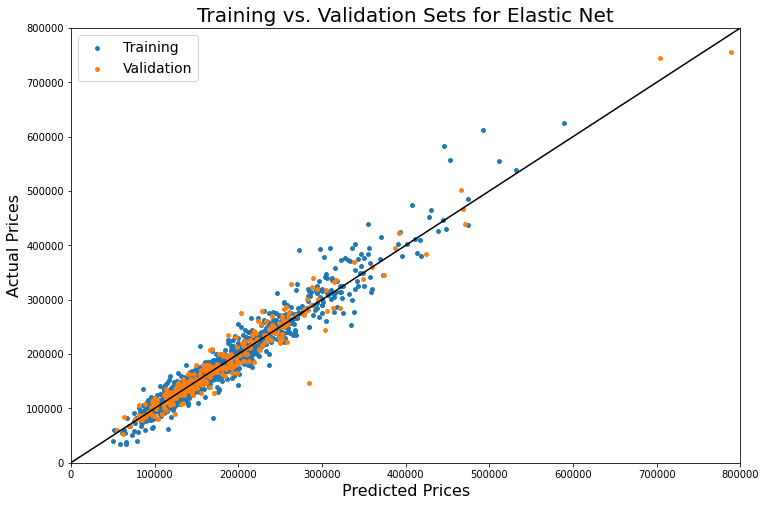

In [170]:
# Plot Elastic Nest Error
plt.figure(figsize=(12,8))
plt.scatter(np.exp(ytrain_lasso), np.exp(ytrain), marker="o", s=15, label = "Training")
plt.scatter(np.exp(ytest_lasso), np.exp(ytest), marker="o", s=15, label="Validation")
plt.title("Training vs. Validation Sets for Elastic Net", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.legend(loc = "upper left", fontsize = 14)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.plot([0, 800000], [0, 800000], 'black') # ideal predict-
#plt.show()
plt.savefig('../output/elasticnet_train_validation_compare.png')

## 3. Random Forest
<a id='rf'></a>

### _data set preparation: categorical to numeric conversion_

In [187]:
# use ordinal data set
df = traino.copy()

# function to covert categorical data to integer
def text_to_num(x):
    '''get a column as param and return column coded in numeric
    from 1 to len of columns'''
    feature = set(x.to_list())
    #get a mapping of feature with their index from 1
    feature_dict = dict(zip( sorted(feature),range(1,len(feature)+1)))
    return x.map(feature_dict)

#get only categorical columns
text_col = df[~df.applymap(np.isreal)].dropna(axis=1).columns
#transform apply function on text columns and create a temp df
num_col = df[text_col].apply(text_to_num)
#Drop text column and merge data frame to create a full df.
tran_df = pd.concat((df.drop(text_col, axis = 1),num_col), axis=1)
print(tran_df.shape)
tran_df.head()

(1460, 84)


,MSSubClass,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,decade_YearBuilt,decade_YearRemodAdd,decade_GarageYrBlt,logSalePrice,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65,8450,3,7,5,2003,2003,196,4,3,4,3,1,6,706,1,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,2003,2,2,548,3,3,0,61,0,0,0,0,0,0,2,2008,208500,10,10,10,12.247694,4,2,2,4,4,1,5,6,3,3,1,6,2,2,13,14,2,3,2,2,5,2,3,5,2,9,5
2,20,80,9600,3,6,8,1976,1976,0,3,3,4,3,4,5,978,1,0,284,1262,5,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,1976,2,2,460,3,3,298,0,0,0,0,0,0,0,5,2007,181500,7,7,7,12.109011,4,2,2,4,4,1,3,25,2,3,1,3,2,2,9,9,3,2,2,2,5,2,3,5,2,9,5
3,60,68,11250,3,7,5,2001,2002,162,4,3,4,3,2,6,486,1,0,434,920,5,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,2001,2,2,608,3,3,0,42,0,0,0,0,0,0,9,2008,223500,10,10,10,12.317167,4,2,2,1,4,1,5,6,3,3,1,6,2,2,13,14,2,3,2,2,5,2,3,5,2,9,5
4,70,60,9550,3,7,5,1915,1970,0,3,3,3,4,1,5,216,1,0,540,756,4,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,1998,1,3,642,3,3,0,35,272,0,0,0,0,0,2,2006,140000,1,7,9,11.849398,4,2,2,1,4,1,1,7,3,3,1,6,2,2,14,16,3,1,2,2,5,6,3,5,2,9,1
5,60,84,14260,3,8,5,2000,2000,350,4,3,4,3,3,6,655,1,0,490,1145,5,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,3,2000,2,3,836,3,3,192,84,0,0,0,0,0,0,12,2008,250000,10,10,10,12.429216,4,2,2,1,4,1,3,14,3,3,1,6,2,2,13,14,2,3,2,2,5,2,3,5,2,9,5


In [190]:
## split to train & validation 
xtrain, xtest, ytrain, ytest = train_test_split(tran_df.drop(['SalePrice', 'logSalePrice'], axis = 1), tran_df.logSalePrice, test_size = 0.2, random_state = 4)

### _s_

In [191]:
rfreg = RandomForestRegressor(random_state=4, max_features=40, oob_score = True, 
                              n_estimators = 700, min_samples_leaf = 20, max_depth = 51)
rfreg.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=51, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)

In [199]:
# random forest prediction
randomforest_pred_train = rfreg.predict(xtrain)
randomforest_pred_test = rfreg.predict(xtest)
MSE = mean_squared_error(ytrain, randomforest_pred_train)
print(f"MSE is {MSE}")
print("train score is", rfreg.score(xtrain, ytrain))
print("oob score is", rfreg.oob_score_)

k5 = KFold(5, random_state=4, shuffle=True)
cv_score = cross_val_score(rfreg, xtrain, ytrain, cv = k5).mean()
print("validation score is", cv_score)

feature_importance = list(zip(xtrain.columns[:], rfreg.feature_importances_))
rf_feature_imp = pd.DataFrame(feature_importance, columns = ["predictor", "importance"]).sort_values(by = "importance", ascending=False)
rf_feature_imp.to_csv("../output/rf_feature_imp.csv")

MSE is 0.020265020318769145
train score is 0.8759946904948082
oob score is 0.8404195011571122
validation score is 0.8323882754208334


### _random search for Random Forest_

In [200]:
## parameter tuning for random forest
params_rf = [{'max_features': range(20,51,10), 'n_estimators': range(200, 1001, 100), 
              'max_depth': range(1,81,10), 'min_samples_leaf': range(10,31,5)}]
random_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=4, oob_score = True), param_distributions = params_rf, 
                               n_iter = 100, cv = 5, verbose = 2, random_state=4)
%time random_rf.fit(xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61, total=   2.1s
[CV] n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61, total=   2.0s
[CV] n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61 
[CV]  n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61, total=   3.0s
[CV] n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61 
[CV]  n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61, total=   2.3s
[CV] n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61 
[CV]  n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=61, total=   2.0s
[CV] n_estimators=400, min_samples_leaf=10, max_features=30, max_depth=11 
[CV]  n_estimators=400, min_samples_leaf=10, max_features=30, max_depth=11, total=   1.7s
[CV] n_estimators=400, min_samples_leaf=10, max_features=30, max_depth=11 
[CV]  n_estimators=400, min_samples_leaf=10, max_features=30, max_depth=11, total=   1.8s
[CV] n_estimators=400, min_samples_leaf=10, max_features=30, max_depth=11 
[CV]  n_es

[CV]  n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=1, total=   1.4s
[CV] n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=1 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=1, total=   1.8s
[CV] n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=1 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=1, total=   1.6s
[CV] n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=1 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=30, max_depth=1, total=   1.4s
[CV] n_estimators=500, min_samples_leaf=30, max_features=30, max_depth=41 
[CV]  n_estimators=500, min_samples_leaf=30, max_features=30, max_depth=41, total=   2.0s
[CV] n_estimators=500, min_samples_leaf=30, max_features=30, max_depth=41 
[CV]  n_estimators=500, min_samples_leaf=30, max_features=30, max_depth=41, total=   1.8s
[CV] n_estimators=500, min_samples_leaf=30, max_features=30, max_depth=41 
[CV]  n_estimator

[CV]  n_estimators=400, min_samples_leaf=15, max_features=40, max_depth=51, total=   2.0s
[CV] n_estimators=400, min_samples_leaf=15, max_features=40, max_depth=51 
[CV]  n_estimators=400, min_samples_leaf=15, max_features=40, max_depth=51, total=   1.9s
[CV] n_estimators=400, min_samples_leaf=15, max_features=40, max_depth=51 
[CV]  n_estimators=400, min_samples_leaf=15, max_features=40, max_depth=51, total=   2.0s
[CV] n_estimators=400, min_samples_leaf=15, max_features=40, max_depth=51 
[CV]  n_estimators=400, min_samples_leaf=15, max_features=40, max_depth=51, total=   2.0s
[CV] n_estimators=500, min_samples_leaf=30, max_features=50, max_depth=21 
[CV]  n_estimators=500, min_samples_leaf=30, max_features=50, max_depth=21, total=   2.3s
[CV] n_estimators=500, min_samples_leaf=30, max_features=50, max_depth=21 
[CV]  n_estimators=500, min_samples_leaf=30, max_features=50, max_depth=21, total=   2.5s
[CV] n_estimators=500, min_samples_leaf=30, max_features=50, max_depth=21 
[CV]  n_es

[CV]  n_estimators=400, min_samples_leaf=10, max_features=50, max_depth=21, total=   3.0s
[CV] n_estimators=400, min_samples_leaf=10, max_features=50, max_depth=21 
[CV]  n_estimators=400, min_samples_leaf=10, max_features=50, max_depth=21, total=   2.9s
[CV] n_estimators=400, min_samples_leaf=10, max_features=50, max_depth=21 
[CV]  n_estimators=400, min_samples_leaf=10, max_features=50, max_depth=21, total=   2.6s
[CV] n_estimators=400, min_samples_leaf=10, max_features=50, max_depth=21 
[CV]  n_estimators=400, min_samples_leaf=10, max_features=50, max_depth=21, total=   2.7s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=51 
[CV]  n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=51, total=   3.8s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=51 
[CV]  n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=51, total=   4.5s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=51 
[CV]  n_es

[CV]  n_estimators=800, min_samples_leaf=10, max_features=20, max_depth=21, total=   3.2s
[CV] n_estimators=800, min_samples_leaf=10, max_features=20, max_depth=21 
[CV]  n_estimators=800, min_samples_leaf=10, max_features=20, max_depth=21, total=   3.0s
[CV] n_estimators=800, min_samples_leaf=10, max_features=20, max_depth=21 
[CV]  n_estimators=800, min_samples_leaf=10, max_features=20, max_depth=21, total=   3.8s
[CV] n_estimators=800, min_samples_leaf=10, max_features=20, max_depth=21 
[CV]  n_estimators=800, min_samples_leaf=10, max_features=20, max_depth=21, total=   3.6s
[CV] n_estimators=700, min_samples_leaf=20, max_features=40, max_depth=71 
[CV]  n_estimators=700, min_samples_leaf=20, max_features=40, max_depth=71, total=   3.6s
[CV] n_estimators=700, min_samples_leaf=20, max_features=40, max_depth=71 
[CV]  n_estimators=700, min_samples_leaf=20, max_features=40, max_depth=71, total=   4.1s
[CV] n_estimators=700, min_samples_leaf=20, max_features=40, max_depth=71 
[CV]  n_es

[CV]  n_estimators=1000, min_samples_leaf=15, max_features=40, max_depth=41, total=   6.1s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=40, max_depth=41 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=40, max_depth=41, total=   4.4s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=40, max_depth=41 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=40, max_depth=41, total=   5.1s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=40, max_depth=41 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=40, max_depth=41, total=   5.5s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=31 
[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=31, total=   2.5s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=31 
[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=31, total=   1.9s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=31 
[CV

[CV]  n_estimators=300, min_samples_leaf=30, max_features=50, max_depth=51, total=   2.2s
[CV] n_estimators=300, min_samples_leaf=30, max_features=50, max_depth=51 
[CV]  n_estimators=300, min_samples_leaf=30, max_features=50, max_depth=51, total=   1.6s
[CV] n_estimators=300, min_samples_leaf=30, max_features=50, max_depth=51 
[CV]  n_estimators=300, min_samples_leaf=30, max_features=50, max_depth=51, total=   1.8s
[CV] n_estimators=300, min_samples_leaf=30, max_features=50, max_depth=51 
[CV]  n_estimators=300, min_samples_leaf=30, max_features=50, max_depth=51, total=   1.5s
[CV] n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=51 
[CV]  n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=51, total=   2.4s
[CV] n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=51 
[CV]  n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=51, total=   4.0s
[CV] n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=51 
[CV]  n_es

[CV]  n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=11, total=   2.9s
[CV] n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=11 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=11, total=   4.2s
[CV] n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=11 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=11, total=   3.8s
[CV] n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=11 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=11, total=   3.4s
[CV] n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=61 
[CV]  n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=61, total=   1.2s
[CV] n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=61 
[CV]  n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=61, total=   1.2s
[CV] n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=61 
[CV]  n_es

[CV]  n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=41, total=   1.2s
[CV] n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=41 
[CV]  n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=41, total=   1.1s
[CV] n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=41 
[CV]  n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=41, total=   1.2s
[CV] n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=41 
[CV]  n_estimators=200, min_samples_leaf=10, max_features=40, max_depth=41, total=   1.1s
[CV] n_estimators=800, min_samples_leaf=15, max_features=20, max_depth=41 
[CV]  n_estimators=800, min_samples_leaf=15, max_features=20, max_depth=41, total=   2.8s
[CV] n_estimators=800, min_samples_leaf=15, max_features=20, max_depth=41 
[CV]  n_estimators=800, min_samples_leaf=15, max_features=20, max_depth=41, total=   3.0s
[CV] n_estimators=800, min_samples_leaf=15, max_features=20, max_depth=41 
[CV]  n_es

[CV]  n_estimators=900, min_samples_leaf=10, max_features=40, max_depth=51, total=   4.7s
[CV] n_estimators=900, min_samples_leaf=10, max_features=40, max_depth=51 
[CV]  n_estimators=900, min_samples_leaf=10, max_features=40, max_depth=51, total=   4.7s
[CV] n_estimators=900, min_samples_leaf=10, max_features=40, max_depth=51 
[CV]  n_estimators=900, min_samples_leaf=10, max_features=40, max_depth=51, total=   4.9s
[CV] n_estimators=900, min_samples_leaf=10, max_features=40, max_depth=51 
[CV]  n_estimators=900, min_samples_leaf=10, max_features=40, max_depth=51, total=   4.5s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=1 
[CV]  n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=1, total=   2.4s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=1 
[CV]  n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=1, total=   2.1s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=1 
[CV]  n_estimat

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 22.1min finished


CPU times: user 19min 55s, sys: 22.2 s, total: 20min 17s
Wall time: 22min 13s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [188]:
print("Random Forest best parameters are", random_rf.best_params_)
print(random_rf.best_score_) # validation score
print(random_rf.best_estimator_)
model_rf = random_rf.best_estimator_
model_rf.fit(xtrain, ytrain)

NameError: name 'random_rf' is not defined

In [170]:
model_rf.score(xtrain, ytrain)

0.9108719955527298

In [140]:
## gridsearch of random forest
params_rf_grid = [{'max_features': range(0,81,10), 'n_estimators': range(100, 501, 5), 
              'max_depth': range(10,101,10), 'min_samples_leaf': range(1,21,1),
             "criterion": ["mse", "mae"]}]

grid_rf = GridSearchCV(RandomForestRegressor(random_state=4, oob_score = True), params_rf_grid, cv=5, n_jobs=-1, verbose = 2, scoring= "neg_mean_squared_error")
%time grid_rf.fit(xtrain, ytrain)

KeyboardInterrupt: 

In [ ]:
display(grid_rf.best_params_)
display(grid_rf.best_score_)
print("The training error is: %.5f" % (1 - grid_rf.score(xtrain, ytrain)))
print("The test error is: %.5f" % (1 - grid_rf.score(xtest, ytest)))

In [ ]:
# plot for random forest
## plot error of train vs validataion data
ytrain_rf = lasso_pred_train
ytest_rf = lasso_pred_test

plt.scatter(np.exp(ytrain_lasso), np.exp(ytrain), marker="o", s=15, label = "Training")
plt.scatter(np.exp(ytest_lasso), np.exp(ytest), marker="o", s=15, label="Validation")

## 4. Multiple Linear Regression 
_**home improvement for homeowners**_
<a id='mlr'></a>

In [ ]:
# features from Lasso?
# multicollinearity still exits, still need to do feature selection / engineer